## 00. 프로젝트 목적

- 본 프로젝트는 Adaptive RAG를 위한 프로젝트입니다.

-  프로젝트 설명

- 고교학점제 전용 챗봇이라는 큰 틀을 먼저 잡고, 그 아래 세부 카테고리를 재정의
    - 운영 문의: 제도, 졸업 요건, 교과 이수 기준 등
    - 과목 선택: 계열/진로 관련 과목, 이수 단위 관련 질문
    - 입시 연계: 대입, 학과, 진학에 유리한 과목 조합 등
    - 도서/자료 추천: 진로에 맞는 책이나 자료
    - 서비스 이용 문의: 챗봇 사용법, 시스템 오류 등

### 필요한 환경변수 정의

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv
import os

# API 키 정보 로드
load_dotenv()

# API 키 읽어오기
openai_api_key = os.environ.get('OPENAI_API_KEY')
pinecone_api_key = os.environ.get("PINECONE_API_KEY")
MONGODB_URI = os.environ.get("MONGODB_URI")
cohere_api_key = os.environ.get("COHERE_API_KEY")

In [2]:
from langchain_pinecone import PineconeVectorStore
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_community.tools import TavilySearchResults
from langchain_core.tools import tool
from typing import List
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank
from langchain_community.llms import Cohere

c:\Users\82106\bearable_chatbot\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 01. Tool 정의

In [3]:
from langchain_pinecone import PineconeVectorStore
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_community.tools import TavilySearchResults
from langchain_core.tools import tool
from typing import List

In [4]:
# OpenAI 임베딩 인스턴스 생성
embeddings = OpenAIEmbeddings(
    model='text-embedding-3-large',
    openai_api_key=openai_api_key
)

C:\Users\82106\AppData\Local\Temp\ipykernel_36296\2547862309.py:2: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(


In [5]:
compressor = CohereRerank(model="rerank-multilingual-v3.0",top_n=4)

In [6]:
# 운영 문의 정보 검색
pinecone_policy = PineconeVectorStore.from_documents(
    documents=[], # 빈 리스트로 초기화
    index_name="myfolio-chatbot",   # 인덱스 이름
    embedding=embeddings,               # 임베딩 인스턴스
    pinecone_api_key=pinecone_api_key,
    namespace="policy", # 네임스페이스 설정 : 운영 문의 -> policy
)

# 2. Pinecone 리트리버를 LangChain retriever로 감싸기
policy_retriever = pinecone_policy.as_retriever(search_kwargs={"k": 5})

compression_retriever_policy = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=policy_retriever
)

# 운영 정보 검색 tool 정의
@tool
def search_policy(query: str) -> List[Document]:
    """
    Securely search and access operational information related to the High School Credit System,
    including graduation requirements, academic regulations, subject completion standards, and general policy guidelines.

    To maintain data integrity and clarity, use this tool only for questions about system operations of the High School Credit System,
    such as curriculum rules, credit units, or graduation criteria.
    """
    docs = compression_retriever_policy.invoke(query)
    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]

In [7]:
# 과목 정보 검색
pinecone_subject = PineconeVectorStore.from_documents(
    documents=[], # 빈 리스트로 초기화
    index_name="myfolio-chatbot",   # 인덱스 이름
    embedding=embeddings,               # 임베딩 인스턴스
    pinecone_api_key=pinecone_api_key,
    namespace="subject", # 네임스페이스 설정: 과목 문의 -> subject
)

# 2. Pinecone 리트리버를 LangChain retriever로 감싸기
subject_retriever = pinecone_subject.as_retriever(search_kwargs={"k": 5})

compression_retriever_subject = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=subject_retriever
)

# 과목 점보 검색 tool 정의
@tool
def search_subject(query: str) -> List[Document]:
    """
    Securely search and access information about subject within the High School Credit System,  
    including subject descriptions, learning objectives, curriculum content, and their relevance to specific career paths.

    To ensure appropriate guidance, use this tool only for questions related to subject within the High School Credit System
    """
    docs = compression_retriever_subject.invoke(query)
    if docs:
        return docs
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]

In [8]:
# 입시 정보 검색
pinecone_admission = PineconeVectorStore.from_documents(
    documents=[], # 빈 리스트로 초기화
    index_name="myfolio-chatbot",   # 인덱스 이름
    embedding=embeddings,               # 임베딩 인스턴스
    pinecone_api_key=pinecone_api_key,
    namespace="admission", # 네임스페이스 설정: 과목 문의 -> subject
)

# 2. Pinecone 리트리버를 LangChain retriever로 감싸기
admission_retriever = pinecone_admission.as_retriever(search_kwargs={"k": 20})

compression_retriever_admission = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=admission_retriever
)

# 입시 점보 검색 tool 정의
@tool
def search_admission(query: str) -> List[Document]:
    """
    Securely search and access information related to college admissions in the context of the High School Credit System,  
    including university overviews, academic majors, academic tracks (계열), and admission procedures.

    To maintain clarity and relevance, use this tool only for questions about college and major selection,  
    such as introductions to specific universities, departments, or entrance examination methods.
    """

    docs = compression_retriever_admission.invoke(query)
    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]

In [9]:
# 도서 정보 검색
pinecone_book = PineconeVectorStore.from_documents(
    documents=[], # 빈 리스트로 초기화
    index_name="myfolio-chatbot",   # 인덱스 이름
    embedding=embeddings,               # 임베딩 인스턴스
    pinecone_api_key=pinecone_api_key,
    namespace="book", # 네임스페이스 설정: 과목 문의 -> subject
)

# 2. Pinecone 리트리버를 LangChain retriever로 감싸기
book_retriever = pinecone_book.as_retriever(search_kwargs={"k": 8})

compression_retriever_book = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=book_retriever
)

# 도서 추천 검색 tool 정의
@tool
def search_book(query: str) -> List[Document]:
    """
    Search and access book recommendations tailored to specific majors or academic tracks,  
    along with brief summaries for each recommended title.

    Use this tool only for questions about books related to a student’s interests or field of study.
    """

    docs = compression_retriever_book.invoke(query)
    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]

In [10]:
# 서비스 관련 정보 검색
pinecone_service = PineconeVectorStore.from_documents(
    documents=[], # 빈 리스트로 초기화
    index_name="myfolio-chatbot",   # 인덱스 이름
    embedding=embeddings,               # 임베딩 인스턴스
    pinecone_api_key=pinecone_api_key,
    namespace="service", # 네임스페이스 설정: 고교학점제 -> curriculum, 진로&진학 상담 -> course, 서비스 문의 -> service
)

# 2. Pinecone 리트리버를 LangChain retriever로 감싸기
service_retriever = pinecone_service.as_retriever(search_kwargs={"k": 5})

# 3. 리랭커를 포함한 리트리버 생성
compression_retriever_service = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=service_retriever
)

# 서비스 검색
@tool
def search_service(query: str) -> List[str]:
    """
    Securely search and access service-related information for the Myfolio service-related information,  
    including how to use the chatbot and how to resolve issues related to the Myfolio service.

    Use this tool only for service-related queries, such as usage instructions or customer support requests.
    """

    docs = compression_retriever_service.invoke(query)
    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]

In [11]:
# 도구 목록을 정의 
tools = [search_policy, search_subject, search_admission, search_book, search_service]

In [12]:
from langchain_openai import ChatOpenAI
from pprint import pprint

# 기본 LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, streaming=True)

# LLM에 도구 바인딩하여 추가 
llm_with_tools = llm.bind_tools(tools)

In [13]:
# 메뉴 검색에 관련된 질문을 하는 경우 -> 메뉴 검색 도구를 호출  
query = "고교학점제 졸업요건은 뭔가요?"
ai_msg = llm_with_tools.invoke(query)

pprint(ai_msg)
print("-" * 100)

pprint(ai_msg.content)
print("-" * 100)

pprint(ai_msg.tool_calls)
print("-" * 100)

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_3O6B1mLpNbWu4wEKTuwy4uN4', 'function': {'arguments': '{"query":"고교학점제 졸업요건"}', 'name': 'search_policy'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef'}, id='run--818cd8e0-24a0-4e32-886a-0161a69e6b3f-0', tool_calls=[{'name': 'search_policy', 'args': {'query': '고교학점제 졸업요건'}, 'id': 'call_3O6B1mLpNbWu4wEKTuwy4uN4', 'type': 'tool_call'}])
----------------------------------------------------------------------------------------------------
''
----------------------------------------------------------------------------------------------------
[{'args': {'query': '고교학점제 졸업요건'},
  'id': 'call_3O6B1mLpNbWu4wEKTuwy4uN4',
  'name': 'search_policy',
  'type': 'tool_call'}]
----------------------------------------------------------------------------------------------------


## 02. State 정의

In [14]:
from typing import TypedDict, List
from langchain_core.documents import Document

# 상태 Schema 정의 
class AdaptiveRagState(TypedDict, total=False):
    question: str
    documents: List[Document]
    generation: str
    category: str
    user_id: str  # 유저 아이디를 넣을 수 있음

# 유저 아이디도 넣을 수는 있는데! 이거는 베어러블이랑 논의를 해봐야함.

## 02-1. SAFEGUARD 정의

In [15]:
from transformers import TextClassificationPipeline, BertForSequenceClassification, AutoTokenizer

# 최초 1회만 실행해서 모델 로딩
def load_unsmile_pipeline(device: int = -1):
    model_name = 'smilegate-ai/kor_unsmile'
    model = BertForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return TextClassificationPipeline(
        model=model,
        tokenizer=tokenizer,
        device=device,  # -1 for CPU, 0 for GPU
        return_all_scores=True,
        function_to_apply='sigmoid'
    )

unsmile_pipe = load_unsmile_pipeline(device=-1)

Device set to use cpu
c:\Users\82106\bearable_chatbot\.venv\lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [16]:
def profanity_prevention(state: dict, pipe: TextClassificationPipeline) -> dict:
    question = state.get("question", "")
    if not question.strip():
        return state

    result = pipe(question)[0]
    scores = {r['label']: r['score'] for r in result}

    if scores.get('악플/욕설', 0) > 0.5 or scores.get('clean', 1) < 0.3:
        new_state = {
            **state,
            "generation": "⚠️ 부적절한 언어가 포함되어 있습니다.",
            "stop": True
        }

        return new_state

    return state

In [17]:
def check_profanity_result(state):
    if state.get("stop"):
        return "__end__"
    return "route_question_adaptive"

### 02-2 줄임말 사전

In [18]:
import re
import json
import requests
import openai

# ─────────────────────────────────────────────────────────────────────────────
# 1) GitHub에서 슬랭 사전 JSON을 가져와 파싱
# ─────────────────────────────────────────────────────────────────────────────
url = "https://raw.githubusercontent.com/bdajiny/slang-dictionary/refs/heads/main/slang_dict.json"
response = requests.get(url)
raw_text = response.text
slang_dict = json.loads(raw_text) # JSON 문자열을 파싱하여 딕셔너리로 변환!


# ─────────────────────────────────────────────────────────────────────────────
# 2) slangword_translate(): 한 번의 re.sub()로 모든 키-치환
# ─────────────────────────────────────────────────────────────────────────────
def slangword_translate(text: str, slang_dict: dict) -> str:
    """
    문장 내 모든 슬랭(줄임말)을 "(슬랭/정식표현)" 형태로 치환하여 반환합니다.
    - 키가 겹치는 경우(예: "국숭세" vs "국숭세단"), 길이 순(긴 것부터) 정렬 후 regex 생성
    """
    # 2-1) 키들을 길이 내림차순으로 정렬 (긴 키가 먼저 매칭되도록)
    sorted_slangs = sorted(slang_dict.keys(), key=len, reverse=True)
    escaped_keys  = [re.escape(s) for s in sorted_slangs]
    combined_re   = re.compile("(" + "|".join(escaped_keys) + ")")

    # 2-2) 치환 콜백: 매칭된 키(found) → "(found/formal)" 형태로 리턴
    def _repl(m: re.Match) -> str:
        found = m.group(1)         # 예: "과탐" 또는 "사탐"
        formal = slang_dict[found] # 예: "과학탐구영역" 또는 "사회탐구영역"
        return f"({found}/{formal})"

    # 2-3) 한 번만 re.sub() 수행
    return combined_re.sub(_repl, text)


# ─────────────────────────────────────────────────────────────────────────────
# 3) select_contextual_word(): 
#    문장 내 여러 개의 "(슬랭/정식)" 각각에 대해 둘 중 하나를 선택하여
#    전체 문장을 완성하는 프롬프트
# ─────────────────────────────────────────────────────────────────────────────
def select_contextual_word(input_translate: str) -> str:
    """
    GPT-4o-mini 모델을 사용하여, input_translate 문자열 안에 여러 개의
    '(슬랭/정식)' 형태가 있을 때, 각 괄호마다 문맥에 맞는 어구 하나씩을
    선택하여 전체 문장을 완성하고 반환합니다.
    - 괄호가 여러 개일 수 있으며, 각각에 대해 둘 중 하나를 선택해야 합니다.
    - 출력 시 괄호와 슬래시(/)는 모두 제거하고, 나머지 원문 텍스트를 보존합니다.
    - 원래 문장의 어미/조사 등은 변경하지 마세요.
    """
    system_prompt = (
        "다음 문장에는 여러 개의 괄호 안에 슬래시(/)로 병기된 두 어구(phrase)가 있습니다.\n"
        "각 괄호마다 두 어구 중 문맥상 더 적절한 어구 하나를 선택하여, \n"
        "전체 문장을 완성한 후 반환하세요.\n"
        "반드시 괄호와 슬래시를 제거하고, 선택된 어구 각각으로만 교체해야 합니다.\n"
        "그 외의 원래 텍스트(어미, 조사, 띄어쓰기 등)는 절대 변경하지 마세요."
    )
    response = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system",  "content": system_prompt},
            {"role": "user",    "content": input_translate}
        ]
    )
    return response.choices[0].message.content.strip()


# ─────────────────────────────────────────────────────────────────────────────
# 4) replace_slang_word(): 슬랭 포함 시 (1)→(2)→(3) 순으로 처리
# ─────────────────────────────────────────────────────────────────────────────
def replace_slang_word(text: str, slang_dict: dict) -> dict:
    """
    1) text에 슬랭이 하나라도 있으면:
       1-1) slangword_translate(text) → "(슬랭/정식)" 형태의 중간 문자열(intermediate) 생성
       1-2) intermediate에서 "(.../...)" 내부의 '정식 부분'에 쉼표(,)가 있으면:
            - 그 "(슬랭/정식)" 패턴만 '정식'으로 대체하고, 나머지 텍스트 그대로 보존
       1-3) 쉼표가 없는 경우:
            - select_contextual_word(intermediate)로 GPT에게 “여러 괄호 각각에 대해 둘 중 하나씩”
              선택한 전체 문장을 반환하도록 요청.
            - 반환된 문장을 그대로 리턴
    2) text에 슬랭이 없으면 {"question": text} 반환
    """
    # (1) text에 슬랭이 포함되어 있는지 확인
    if any(s in text for s in slang_dict):
        # (1-1) "(슬랭/정식)" 형태로 치환 → 중간 문자열
        intermediate = slangword_translate(text, slang_dict)
        # ex) "저는 (과탐/과학탐구영역)과 (사탐/사회탐구영역)을 모두 신청했습니다."

        # (1-2) 각 "(.../...)"에서 slash 뒤 정식(formal_part) 부분 추출
        #     → 첫 번째 매칭만 검사 (정규표현식), 쉼표 포함 여부 확인
        m = re.search(r"\(([^/]+)/([^\)]+)\)", intermediate)
        if m:
            formal_part = m.group(2).strip()
            if "," in formal_part:
                # 쉼표가 포함된 경우:
                # "(슬랭/정식)" 전부를 "정식"으로 바꾸고 나머지 텍스트 보존
                result_text = re.sub(r"\([^/]+/([^\)]+)\)", r"\1", intermediate)
                return {"question": result_text}

        # (1-3) 쉼표가 없다면: GPT에게 “여러 괄호 각각에 대해” 선택을 요청
        final_text = select_contextual_word(intermediate)
        return {"question": final_text}

    # (2) 슬랭이 없으면: 원문 그대로 반환
    else:
        return {"question": text}

## 03. 질문 분석 후 라우팅

In [20]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from textwrap import dedent

# 라우팅 결정용 데이터 모델
class ToolSelector(BaseModel):
    """Routes the user question to the most appropriate tool."""
    tool: Literal[
        "search_policy", 
        "search_subject", 
        "search_admission", 
        "search_book", 
        "search_service"
    ] = Field(
        description="Select one of the tools: search_policy, search_subject, search_admission, search_books, or search_service based on the user's question."
    )

# 구조화된 출력을 위한 LLM 설정
structured_llm = llm.with_structured_output(ToolSelector)

# 라우팅을 위한 프롬프트 템플릿
system = dedent("""You are a high school curriculum chatbot that classifies user questions into one of five categories.

Use the following routing rules:

- If the question is about how the 고교학점제 is operated—such as graduation requirements, subject completion standards, school-level implementation, course registration, or the 성취평가제—use the **search_policy** tool.

- If the question is about specific school subjects—such as what is taught in each subject, subject selection criteria, subject classification (예: 일반 선택, 진로 선택), or recommended subjects based on career interests—use the **search_subject** tool.

- If the question asks about university admissions or majors—such as what departments exist, what a certain major is about or teaches, what "계열" (academic tracks) are available, how entrance exams work, or how to prepare for 전형 types like 수시, 정시, 학과 and 학종—use the **search_admission** tool. For example, questions like “What do you learn in 호텔경영학과?” or “Tell me about 서울대 경영학과” belong here.
               and if the user asks about a university, such as in "신한대학교에 대해 알려줘", extract only the key term immediately preceding "대학교" or "대" (e.g., "신한") and use it as the core search keyword.

- If the question asks for book recommendations or summaries related to specific majors, subjects, or academic interests, use the **search_book** tool.

- If the question is about how to use the chatbot or about issues related to the MyFolio service, use the **search_service** tool.

- If the user's input includes keywords such as "세특", "수행평가", "주제", or phrases asking "what should I do", assume they are asking for a topic suggestion. In those cases, respond only with the link: https://myfolio.im/seteuk

Always choose the single most relevant tool that best matches the user's intent.
""")

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# 질문 라우터 정의
question_router = route_prompt | structured_llm

# 테스트 실행
print(question_router.invoke({"question": "고교학점제 졸업 요건에 대해 설명해줘"}))
print(question_router.invoke({"question": "경영학과 가고 싶은데, 어떤 과목을 들어야 하나요?"}))
print(question_router.invoke({"question": "서울대학교 경영학과에 대해 알려줘."}))
print(question_router.invoke({"question": "경영학과에 도움되는 도서 추천해줘."}))
print(question_router.invoke({"question": "베어러블의 세특 추천 서비스 이용 방법이 궁금해요."}))
print(question_router.invoke({"question": "경영학과 갈려면 １학년 과목 뭐 들어야해?"}))

tool='search_policy'
tool='search_subject'
tool='search_admission'
tool='search_book'
tool='search_service'
tool='search_subject'


In [21]:
# 너의 툴 이름과 함수 맵핑
tool_map = {
    "search_policy": search_policy,
    "search_subject": search_subject,
    "search_admission": search_admission,
    "search_book": search_book,
    "search_service": search_service,
}

def run_tool_and_get_output(question: str) -> dict:
    # 툴 선택 (output은 안 나옴)
    result = question_router.invoke({"question": question})
    tool_name = result.tool

    # 툴 실행 (직접 실행해야 함)
    if tool_name in tool_map:
        output = tool_map[tool_name](question)  # 여기에 실제 검색 결과가 담김
    else:
        output = None

    return {
        "tool": tool_name,
        "output": output
    }

In [22]:
def route_question_adaptive(state: AdaptiveRagState) -> AdaptiveRagState:
    # 1) 슬랭 전처리 (여기서 직접 처리)
    q = state["question"]
    if any(s in q for s in slang_dict.keys()):
        # replace_slang_word 가 {"question": "..."} 를 리턴하므로 
        state["question"] = replace_slang_word(q, slang_dict)["question"]

    # 2) 기존 라우팅 로직
    try:
        result = run_tool_and_get_output(state["question"])
        datasource = result["tool"]
        output = result["output"]
        if isinstance(output, list):
            all_pages = [doc.page_content for doc in output]
            if all("관련 정보를 찾을 수 없습니다" in page for page in all_pages):
                return {**state, "next_node": "llm_fallback"}
        return {**state, "next_node": datasource, "output": output}
    except Exception as e:
        print(f"Error in routing: {str(e)}")
        return {**state, "next_node": "llm_fallback"}

## 04. 검색 노드 설정

In [23]:
def rephrase_question_with_history(memory, current_question):
    history = memory.chat_memory.messages[-3:]  # 최근 5개만
    history_text = "\n".join([
        f"User: {m.content}" if isinstance(m, HumanMessage) else f"Bot: {m.content}"
        for m in history
    ])

    prompt = ChatPromptTemplate.from_messages([
        ("system", "아래는 유저와의 대화 기록이야. 최근 질문을 더 구체적으로 바꿔줘."),
        ("human", f"대화 기록:\n{history_text}\n\n질문: {current_question}\n\n보완된 질문:")
    ])

    rephrase_chain = prompt | llm | StrOutputParser()
    enriched = rephrase_chain.invoke({"question": current_question})
    return enriched

In [24]:
def search_policy_adaptive(state: AdaptiveRagState):
    """
    Node for searching information in the 고교학점제 운영
    """
    question = state["question"]
    user_id = state.get("user_id", "anonymous")
    memory = get_user_memory(user_id)

    # 질문 리프레이징
    enriched_question = rephrase_question_with_history(memory, question)

    docs = search_policy.invoke(enriched_question)
    if len(docs) > 0:
        return {"documents": docs}
    else:
        return {"documents": [Document(page_content="관련 고교학점제 운영 정보를 찾을 수 없습니다.")]}


def search_subject_adaptive(state: AdaptiveRagState):
    """
    Node for searching information in the subject whthin the 고교학점제
    """
    question = state["question"]
    user_id = state.get("user_id", "anonymous")
    memory = get_user_memory(user_id)

    # 질문 리프레이징
    enriched_question = rephrase_question_with_history(memory, question)

    docs = search_subject.invoke(enriched_question)

    if len(docs) > 0:
        return {"documents": docs}
    else:
        return {"documents": [Document(page_content="관련 과목 정보를 찾을 수 없습니다.")]}

def search_admission_adaptive(state: AdaptiveRagState):
    """
    Node for searching information in the admission
    """
    question = state["question"]
    user_id = state.get("user_id", "anonymous")
    memory = get_user_memory(user_id)

    # 질문 리프레이징
    enriched_question = rephrase_question_with_history(memory, question)

    docs = search_admission.invoke(enriched_question)
    if len(docs) > 0:
        return {"documents": docs}
    else:
        return {"documents": [Document(page_content="관련 입시 정보를 찾을 수 없습니다.")]}

def search_book_adaptive(state: AdaptiveRagState):
    """
    Node for searching information in the book
    """
    question = state["question"]
    user_id = state.get("user_id", "anonymous")
    memory = get_user_memory(user_id)

    # 질문 리프레이징
    enriched_question = rephrase_question_with_history(memory, question)
    
    docs = search_book.invoke(enriched_question)
    if len(docs) > 0:
        return {"documents": docs}
    else:
        return {"documents": [Document(page_content="관련 도서 정보를 찾을 수 없습니다.")]}


def search_service_adaptive(state: AdaptiveRagState):
    """
    Node for searching the 베어러블 service information
    """
    question = state["question"]
    user_id = state.get("user_id", "anonymous")
    memory = get_user_memory(user_id)

    # 질문 리프레이징
    enriched_question = rephrase_question_with_history(memory, question)

    docs = search_service.invoke(enriched_question)
    if len(docs) > 0:
        return {"documents": docs}
    else:
        return {"documents": [Document(page_content="관련 베어러블 서비스 정보를 찾을 수 없습니다.")]}

## 05. 생성노드

### 05-1. LOG 저장

In [25]:
from pymongo import MongoClient
from datetime import datetime
import json

# MongoDB Atlas 연결
client = MongoClient(MONGODB_URI)
db = client["chatbot_db"]
collection = db["chat_logs"]

def save_chat_log(user_input, bot_response, category="미지정", user_id = "anonymous"):
    log_entry = {
        "timestamp": datetime.now().isoformat(),
        "user": user_input,
        "bot": bot_response,
        "category": category
    }
    collection.insert_one(log_entry)  # <- 이게 저장하는 코드

### 05-2. 생성노드 생성

In [26]:
from langchain.memory import ConversationBufferWindowMemory
from datetime import datetime, timedelta

# 유저별 메모리와 마지막 활동 시각 저장소
memory_store: dict[str, ConversationBufferWindowMemory] = {}
last_activity: dict[str, datetime] = {}

# 세션 유지 시간 
SESSION_TIMEOUT = timedelta(minutes=5)

# 유지할 최근 메시지 수
WINDOW_SIZE = 3

def get_user_memory(user_id: str) -> ConversationBufferWindowMemory:
    now = datetime.now()

    # 초기화 조건: 세션이 없거나 5분 이상 경과 시
    if (
        user_id not in memory_store or
        user_id not in last_activity or
        now - last_activity[user_id] > SESSION_TIMEOUT
    ):
        memory_store[user_id] = ConversationBufferWindowMemory(
            memory_key="chat_history",
            return_messages=True,
            k=WINDOW_SIZE  # 최근 k개 메시지만 유지
        )

    # 활동 시간 갱신
    last_activity[user_id] = now

    return memory_store[user_id]

In [27]:
from langchain_core.messages import HumanMessage, AIMessage
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser  

def generate_adaptive(state: AdaptiveRagState):
    question = state.get("question", "")
    documents = state.get("documents", [])
    user_id = state.get("user_id", "anonymous")

    # 유저 메모리 가져오기
    memory = get_user_memory(user_id)

    if not isinstance(documents, list):
        documents = [documents]

    documents_text = "\n\n".join([
        f"---\n본문: {doc.page_content}\n메타데이터:{str(doc.metadata)}\n---"
        for doc in documents
    ])

    # 이전 대화 이력 가져오기
    history = memory.chat_memory.messages  # 이전 대화 리스트
    history_text = "\n".join([
        f"User: {m.content}" if isinstance(m, HumanMessage) else f"Bot: {m.content}"
        for m in history
    ])

    # RAG 프롬프트 정의
    prompt_with_context = ChatPromptTemplate.from_messages([
        ("system", """You are an assistant answering questions based on provided documents. Follow these guidelines:

    1. Use only information from the given documents.
    2. If the document lacks relevant info, say "The provided documents don't contain information to answer this question."
    3. Cite relevant parts of the document in your answers.
    4. Don't speculate or add information not in the documents.
    5. Keep answers concise and clear.
    6. Omit irrelevant information.
    7. 관련된 문서가 없을 경우, 
        "The provided documents don't contain information to answer this question."라고 답변해줘.
    8. 이모티콘 넣어서 다정하게 답변해줘
    9.If the user's input includes keywords such as "세특", "수행평가", "주제", or phrases asking "what should I do", assume they are asking for a topic suggestion. In those cases, respond only with the link: https://myfolio.im/seteuk
         """

    ),
        ("human", "Answer the following question using these documents:\n\n[Documents]\n{documents}\n\n[Question]\n{question}"),
    ])

    rag_chain = prompt_with_context | llm | StrOutputParser()
    generation = rag_chain.invoke({
        "documents": documents_text,
        "question": question                                    
    })

    # 메모리 & 로그 저장
    memory.chat_memory.add_user_message(HumanMessage(content=question))
    memory.chat_memory.add_ai_message(AIMessage(content=generation))

    save_chat_log(question, generation, user_id=user_id)

    return {"generation": generation}

In [28]:
from langchain_core.messages import HumanMessage, AIMessage
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser  

def llm_fallback_adaptive(state: AdaptiveRagState):
    question = state.get("question", "")
    user_id = state.get("user_id", "anonymous")

    # 유저별 memory 가져오기
    memory = get_user_memory(user_id)

    # 이전 대화 context 구성
    history = memory.chat_memory.messages
    history_text = "\n".join([
        f"User: {m.content}" if isinstance(m, HumanMessage) else f"Bot: {m.content}"
        for m in history
    ])

    # LLM Fallback 프롬프트 정의
    prompt_with_context = ChatPromptTemplate.from_messages([
        ("system", """You are an AI assistant helping with various topics. Follow these guidelines:

    There are two possible situations:

    1. If the {question} is relevant to topics like school policies, curriculum, admissions, book, or services 등 학교에 관련된 정보,
        respond by clearly stating: "관련된 문서를 찾을 수 없습니다."

    2. If the question is unrelated to those topics (e.g., public holidays, general culture, history, daily life),
       simply answer it using your general knowledge.

    In all cases:
    - Provide accurate and helpful information to the best of your ability.
    - Express uncertainty when unsure; avoid speculation.
    - Keep answers concise yet informative.
    - Inform users they can ask for clarification if needed.
    - Respond ethically and constructively.
    - Mention reliable general sources when applicable if needed.
    -If the user's input includes keywords such as "세특", "수행평가", "주제", or phrases asking "what should I do", assume they are asking for a topic suggestion. In those cases, respond only with the link: https://myfolio.im/seteuk

    """),
        ("human", "{question}"),
    ])

    llm_chain = prompt_with_context | llm | StrOutputParser()
    generation = llm_chain.invoke({"question": question})

    # 메모리에 저장
    memory.chat_memory.add_user_message(HumanMessage(content=question))
    memory.chat_memory.add_ai_message(AIMessage(content=generation))

    # 로그 저장
    save_chat_log(question, generation, user_id=user_id)

    return {"generation": generation}

## 06. 그래프 연결

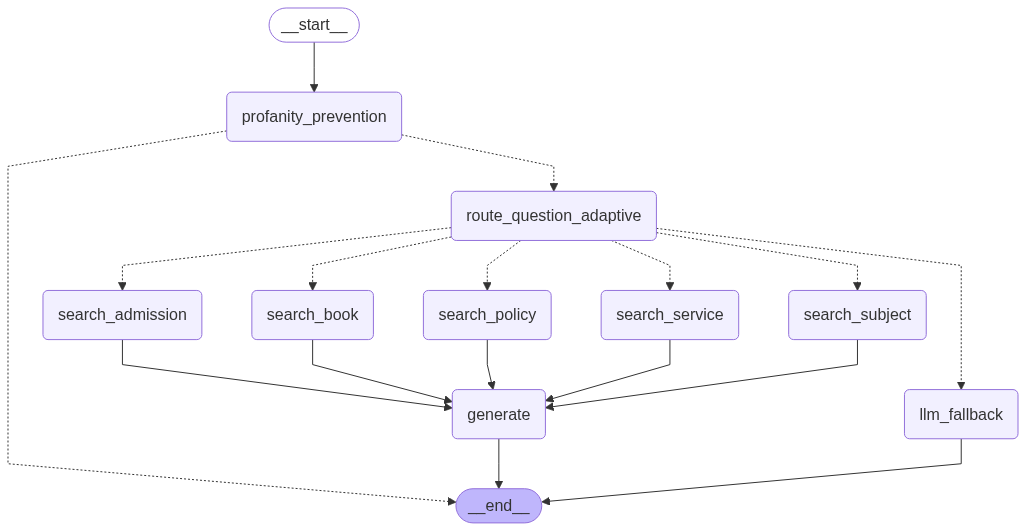

In [29]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from functools import partial

# 그래프 구성
builder = StateGraph(AdaptiveRagState)

builder.set_entry_point("profanity_prevention")

builder.add_node("profanity_prevention", partial(profanity_prevention, pipe=unsmile_pipe))
builder.add_node("route_question_adaptive", route_question_adaptive)

builder.add_node("search_policy", search_policy_adaptive)
builder.add_node("search_subject", search_subject_adaptive)
builder.add_node("search_admission", search_admission_adaptive)
builder.add_node("search_book", search_book_adaptive)
builder.add_node("search_service", search_service_adaptive)

builder.add_node("generate", generate_adaptive)
builder.add_node("llm_fallback", llm_fallback_adaptive)

# profanity 검사 → end 또는 route
builder.add_conditional_edges(
    "profanity_prevention",
    check_profanity_result,
    {
        "__end__": "__end__",
        "route_question_adaptive": "route_question_adaptive"
    }
)

builder.add_conditional_edges(
    "route_question_adaptive",
    lambda state: state["next_node"],  # ✅ 딕셔너리 key 기준 분기
    {
        "search_policy": "search_policy",
        "search_subject": "search_subject",
        "search_admission": "search_admission",
        "search_book": "search_book",
        "search_service": "search_service",
        "llm_fallback": "llm_fallback",
    }
)


# 각 검색 → generate 연결
builder.add_edge("search_policy", "generate")
builder.add_edge("search_subject", "generate")
builder.add_edge("search_admission", "generate")
builder.add_edge("search_book", "generate")
builder.add_edge("search_service", "generate")


builder.add_edge("llm_fallback", "__end__")
builder.add_edge("generate", "__end__")

# 그래프 컴파일 
adaptive_rag = builder.compile()

# 그래프 시각화
display(Image(adaptive_rag.get_graph().draw_mermaid_png(max_retries=10, retry_delay=2.0)))

In [39]:
import random

# user_id를 랜덤으로 생성 (실제 서비스에서는 유저 ID를 세션이나 DB에서 가져와야 함)
random_user_id = f"user_{random.randint(1, 1000)}"

# 그래프 실행
inputs = {"question": "빅데이터응용학과랑 관련된 책 추천해주라","user_id": random_user_id}
for output in adaptive_rag.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}':")
        print(f"State '{value.keys()}':")
        print(f"Value '{value}':")
    print("\n---\n")

# 최종 답변
print(value["generation"])

Node 'profanity_prevention':
State 'dict_keys(['question', 'user_id'])':
Value '{'question': '빅데이터응용학과랑 관련된 책 추천해주라', 'user_id': 'user_626'}':

---

Node 'route_question_adaptive':
State 'dict_keys(['question', 'user_id'])':
Value '{'question': '빅데이터응용학과랑 관련된 책 추천해주라', 'user_id': 'user_626'}':

---

Node 'search_book':
State 'dict_keys(['documents'])':
Value '{'documents': [Document(metadata={'chunk_index': 1.0, 'department': '소프트웨어/AI', 'major': '인공지능/AI', 'num_books': 10.0, 'type': 'merged_book_summaries', 'relevance_score': 0.7446563}, page_content='[책 제목: 벌거벗은 통계학]\n[저자: 찰스 윌런]\n[요약]\n벌거벗은 통계학은 찰스 윌런이 쓴 책으로, 통계학의 기본 개념을 쉽게 이해할 수 있도록 설명한 책입니다. 야구, 선거, 게임, 광고, 마케팅, 복권, 주식, 쇼핑 등 곳곳에서 수시로 통계자료와 확률을 접하는 일반인은 물론, 세일즈맨, 기획자, 투자가, 애널리스트, 광고인, 정치인 등 다각적인 데이터를 분석해 합리적 의사결정을 내려야 하는 사람들까지 쉽고 재미있게 이해할 수 있는 통계의 모든 것을 담고 있습니다.\n[분야]\n소프트웨어/AI\n----------------------------------------\n[책 제목: 베이즈 통계학 입문]\n[저자: 와쿠이 사다미]\n[요약]\n와쿠이 사다미의 \'베이즈 통계학\'은 베이즈 통계학의 기초 개념과 응용 방법을 설명하는 책입니다. 베이즈 통계학은 표본에서 얻은

In [31]:
import random

# random user_id 생성
random_user_id = f"user_{random.randint(1, 1000)}"

while True:

    q = input("\n🧑‍🎓 질문을 입력하세요 (종료하려면 'exit'):")
    if q.lower() == "exit":
        break

    inputs = {"question": q, "user_id": random_user_id}  
    for output in adaptive_rag.stream(inputs):
        for key, value in output.items():
            final_output = value

    print(f"🤖 답변: {final_output['generation']}")

In [32]:
# # 저장 확인 테스트 (최신 memory 인스턴스에서)

# memory = get_user_memory(random_user_id)  # 유저 아이디에 맞는 메모리 가져오기
# for i, msg in enumerate(memory.chat_memory.messages):
#     print(f"[{i}] {msg.type}: {msg.content}")

In [33]:
# collection.delete_many({})